In [1]:
# For Chinese 
# -*- coding=UTF-8 -*-
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import codecs

print(tf.__version__)
%matplotlib inline

1.10.1


In [2]:
#Download the file for train from  http://www.manythings.org/anki/, 
# the corpus is related to translating from Chinese to English

path_to_file = "deu.txt"
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w +' <end>'
    return w


def create_dataset(path, num_examples):
    lines = codecs.open(path, encoding = 'utf-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in line.split('\t')] for line in lines[:num_examples]]
    return word_pairs

In [3]:

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        
        self.vocab = sorted(self.vocab)
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            

In [4]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)
    
    inp_lang = LanguageIndex(en for en, de in pairs)
    targ_lang = LanguageIndex(de for en, de in pairs)
    
    # Vectorize the input and target classes
    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, de in pairs]
    
    # German sentences
    target_tensor = [[targ_lang.word2idx[s] for s in de.split(' ')] for en, de in pairs]
    

    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [5]:
num_examples = 1000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [6]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(800, 800, 200, 200)

In [7]:
# Create tf.data
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


### Encoder and decoder

In [8]:
def gru(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units,
                                        return_sentence = True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')


In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # For Attention
        self.W1 = tf.keras.layers.Dense(self.dec_units) ## ??
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden, 1) 
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis = 1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights
    
    def initial_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [11]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [12]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1- np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    return tf.reduce_mean(loss_)

In [13]:
checkpoint_dir = './train_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [19]:
EPOCHS = 1

for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:,t], predictions)
                dec_input = tf.expand_dims(targ[:,t], 1)
                
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
         # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.1141
Epoch 1 Loss 1.7264
Time taken for 1 epoch 96.7108380795 sec



In [20]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_tarp):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.multinomial(tf.exp(predictions), num_samples = 1)[0][0].numpy() ##?
        result += targ_lang.idx2word[predicted_id] + ' '
        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [21]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [22]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i will go <end>
Predicted translation: ich bin . <end> 


ValueError: Colormap viridis is not recognized

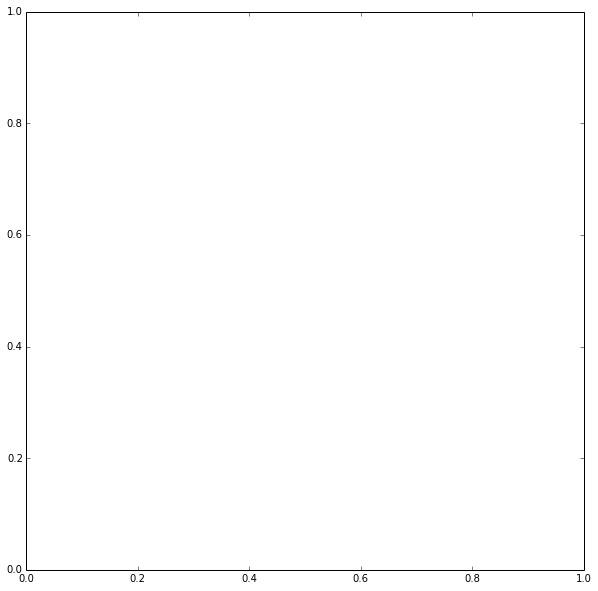

In [24]:
translate(u"I will go", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)